In [ ]:
#Collab bootstrapping for accessing files from google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
#Get test_medium.csv
downloaded = drive.CreateFile({'id':"1nM4xOSa_WPF_9gmFPVMX0LgSXIduTk_X"})
downloaded.GetContentFile('test_medium.csv')

#Get train_medium.csv
downloaded = drive.CreateFile({'id':"1W5RFr2-ZKo-g3nYtPZP2k2-ePHkOKsP2"})
downloaded.GetContentFile('train_medium.csv')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
import csv
import re
import pylab

In [ ]:
#Hyper-parameters and other constants definition
MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
FILTER_SHAPE1 = [20, 256]
FILTER_SHAPE2 = [20, 1]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15

batch_size = 128
one_hot_size = 256
no_epochs = 250
lr = 0.01

seed = 10
tf.random.set_seed(seed)

In [ ]:
# Read data with [character] + other helper functions (from starter code)
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

def preprocess(strings, char_to_ix, MAX_LENGTH):
    data_chars = [list(d.lower()) for _, d in enumerate(strings)]
    for i, d in enumerate(data_chars):
        if len(d)>MAX_LENGTH:
            d = d[:MAX_LENGTH]
        elif len(d) < MAX_LENGTH:
            d += [' '] * (MAX_LENGTH - len(d))
            
    data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
    for i in range(len(data_chars)):
        for j in range(MAX_LENGTH):
            data_ids[i, j] = char_to_ix[data_chars[i][j]]
    return np.array(data_ids)

def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))


    vocab_size, char_to_ix = vocabulary(x_train+x_test)
    x_train = preprocess(x_train, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    return x_train, y_train, x_test, y_test

In [ ]:
#Load the dataset (both train and test set) and conduct necessary preprocessing
x_train, y_train, x_test, y_test = read_data_chars()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [ ]:
print(y_train)

tf.Tensor([ 7  9  4 ...  9  6 12], shape=(5600,), dtype=int64)


In [ ]:
# Model definition (using inheritance to base Model from keras library)
tf.keras.backend.set_floatx('float32')
class CharCNN(Model):
    def __init__(self, vocab_size=256):
        super(CharCNN, self).__init__()
        self.vocab_size = vocab_size
        # Weight variables and CNN cell
        # First Conv and Pooling
        self.conv1 = layers.Conv2D(N_FILTERS, FILTER_SHAPE1, padding='VALID', activation='relu', use_bias=True)
        self.pool1 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        # Second Conv and Pooling
        self.conv2 = layers.Conv2D(N_FILTERS, FILTER_SHAPE2, padding ='VALID', activation='relu', use_bias=True)
        self.pool2 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        # FC layers
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(MAX_LABEL, activation='softmax')

    def call(self, x, drop_rate=0.5):
        # forward
        x = tf.one_hot(x, one_hot_size)
        x = x[..., tf.newaxis] 
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = tf.nn.dropout(x, drop_rate)
        logits = self.dense(x)
        return logits

In [ ]:
model = CharCNN(256)

In [ ]:
# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(label, out)

# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

In [ ]:
#Training
test_acc = []
train_entropy_loss = []
for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for character_ids, labels in train_ds:
        train_step(model, character_ids, labels, drop_rate=0)

    for character_ids, labels in test_ds:
        test_step(model, character_ids, labels, drop_rate=0)

    test_acc.append(test_accuracy.result())
    train_entropy_loss.append(train_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))

Epoch 1, Loss: 2.1793620586395264, Accuracy: 0.2544642984867096, Test Loss: 1.6052465438842773, Test Accuracy: 0.46857142448425293
Epoch 2, Loss: 1.2543829679489136, Accuracy: 0.5817857384681702, Test Loss: 1.2120286226272583, Test Accuracy: 0.6142857074737549
Epoch 3, Loss: 0.9182537198066711, Accuracy: 0.6944642663002014, Test Loss: 1.1729674339294434, Test Accuracy: 0.6414285898208618
Epoch 4, Loss: 0.6671310663223267, Accuracy: 0.7753571271896362, Test Loss: 1.132731556892395, Test Accuracy: 0.6442857384681702
Epoch 5, Loss: 0.5399115085601807, Accuracy: 0.8139285445213318, Test Loss: 1.1522505283355713, Test Accuracy: 0.6728571653366089
Epoch 6, Loss: 0.44408753514289856, Accuracy: 0.8473214507102966, Test Loss: 1.2867255210876465, Test Accuracy: 0.6585714221000671
Epoch 7, Loss: 0.3366347551345825, Accuracy: 0.8901785612106323, Test Loss: 1.3775105476379395, Test Accuracy: 0.6614285707473755
Epoch 8, Loss: 0.28799304366111755, Accuracy: 0.9057142734527588, Test Loss: 1.4770284891

No handles with labels found to put in legend.


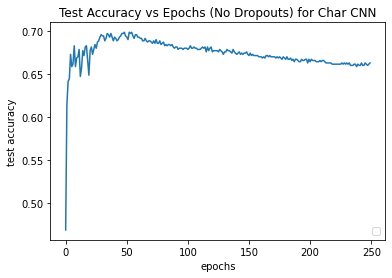

In [ ]:
#Plot test accuracy
pylab.figure()
pylab.plot(np.arange(no_epochs), test_acc)
pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
pylab.title('Test Accuracy vs Epochs (No Dropouts) for Char CNN')
pylab.legend(loc='lower right')
pylab.show()

No handles with labels found to put in legend.


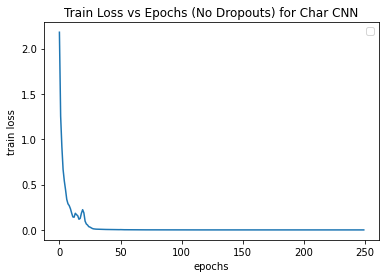

In [ ]:
# Plot train loss
pylab.figure()
pylab.plot(np.arange(no_epochs), train_entropy_loss)
pylab.xlabel('epochs')
pylab.ylabel('train loss')
pylab.title('Train Loss vs Epochs (No Dropouts) for Char CNN')
pylab.legend(loc='upper right')
pylab.show()

In [ ]:
#Obtain best test accuracy for comparison
np.max(test_acc)

0.69857144

In [ ]:
np.min(train_entropy_loss)

3.9897677e-06